<a href="https://colab.research.google.com/github/Radi4/DL_colab/blob/master/homework04_basic_part1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (13, 6)

In [0]:
from tqdm import tnrange

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#cp from gdrive
!cp ./gdrive/'My Drive'/Train_rev1.csv ./

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [6]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

63246     Sales Management Trainee This Is Your Chance T...
18218     Job Purpose As Key Account Manager, you will w...
224846    Find ****s of vacancies like this on the secto...
Name: FullDescription, dtype: object

In [7]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
62093,68699663,Category Specialists,Working within a varied procurement team the s...,Birmingham West Midlands (County) West Midlands,UK,NaN,permanent,Michael Page Procurement & Supply Chain,Other/General Jobs,35000 to 44000 per annum,39500,totaljobs.com,10.584082
90552,69168557,Sales Negotiator,Our Derbyshire based Client are currently recr...,Derby Derbyshire East Midlands,Derby,NaN,permanent,Office Angels,Sales Jobs,12000 - 14000 per annum,13000,totaljobs.com,9.472781
178844,71557855,PartTime Information Assistants x **** positions,PartTime Information Assistants x 2 positions ...,"Portsmouth, Hampshire",Portsmouth,part_time,NaN,R21 Media,Admin Jobs,16425/annum,16425,cv-library.co.uk,9.706621


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [8]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
def increase_token_counts(token_counts, tokens):
  for token in tokens.split(' '):
    token_counts[token] += 1

In [12]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
data["Title"].apply(lambda tokens : increase_token_counts(token_counts, tokens))
data["FullDescription"].apply(lambda tokens : increase_token_counts(token_counts, tokens))
'Finish'

'Finish'

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

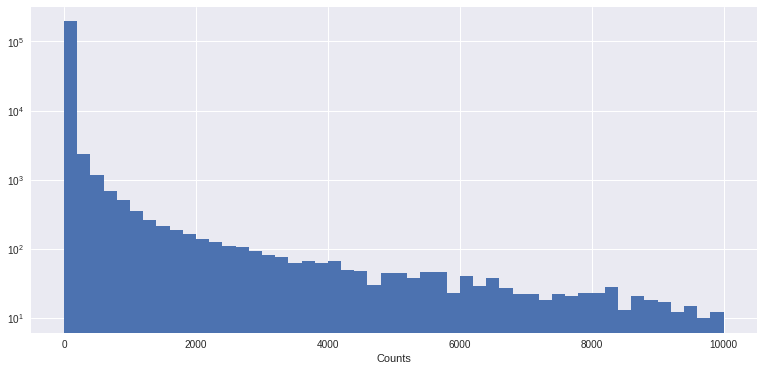

In [14]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, val in token_counts.items() if val >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = {token : index for index, token in enumerate(tokens)}

In [18]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [21]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [22]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [24]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[3199,  558,  559,  944,   73,   74,  813, 5697,   11, 1900],
        [  51, 1231,    6,   92,   74,   74,   82,  282,  880, 1166],
        [ 813,  531,   11,  618,  858,  217,  561,  230, 1399, 1400]],
       dtype=int32),
 'Log1pSalary': array([10.045031, 10.341775, 10.221977], dtype=float32),
 'Title': array([[5697,   11, 1311, 1900,   11, 2155, 1756, 1899,  214, 2180],
        [  51, 1231,    6,    0,    1,    1,    1,    1,    1,    1],
        [4101,  531,   63,  230, 1399, 1400,   64,    1,    1,    1]],
       dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.pool1 = GlobalMaxPooling().cuda()
        self.dense = nn.Linear(out_size, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.pool1(self.conv1(h)))

In [190]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title'])).cuda()
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2).cuda()
        self.conv2 = nn.Conv1d(out_size, out_size * 2, kernel_size=3, padding=1).cuda()
        self.pool2 = GlobalMaxPooling().cuda()
        self.dense = nn.Linear(out_size * 2, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.pool2(self.conv2(self.pool1(self.relu(self.conv1(h))))))

In [192]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription'])).cuda()
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size = 128)
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_1 = nn.Linear(n_cat_features, 512).cuda()
        self.relu_1 = nn.ReLU().cuda()
        self.dense_2 = nn.Linear(512, 256).cuda()
        self.relu_2 = nn.ReLU().cuda()
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(64 + 128 + 256, 1024).cuda()
        self.out_relu = nn.ReLU().cuda()
        self.predict = nn.Linear(1024, 1).cuda()
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.relu_2(self.dense_2(self.relu_1(self.dense_1(cat_features))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        output = self.predict(self.out_relu(self.output(joint_h)))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [0]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [83]:
train_losses = np.zeros(num_epochs).astype(float)
val_losses = np.zeros(num_epochs).astype(float)

train_maes = np.zeros(num_epochs).astype(float)
val_maes = np.zeros(num_epochs).astype(float) 

for epoch_i in tnrange(num_epochs):
    
    if epoch_i % 10 == 0:
      print("Training after {} epochs".format(epoch_i + 1))
    
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, verbose = False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1
    
    train_losses[epoch_i] = train_loss / train_batches
    train_maes[epoch_i] = train_mae / train_batches
    
    if epoch_i % 10 == 0:
      print("\tLoss:\t%.5f" % (train_loss / train_batches))
      print("\tMAE:\t%.5f" % (train_mae / train_batches))
      print('\n\n')
    
    if epoch_i % 10 == 0:
      print("Validation after {} epochs".format(epoch_i + 1))
    
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False, verbose = False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()
        val_batches += 1
    
    val_losses[epoch_i] = val_loss / val_batches
    val_maes[epoch_i] = val_mae / val_batches
    
    if epoch_i % 10 == 0:  
      print("\tLoss:\t%.5f" % (val_loss / val_batches))
      print("\tMAE:\t%.5f" % (val_mae / val_batches))
      print('\n\n')

Training after 1 epochs
	Loss:	4.97355
	MAE:	112690.89960



Validation afte 1 epochs
	Loss:	0.37310
	MAE:	13879.92340



Training after 11 epochs
	Loss:	0.14265
	MAE:	9965.04563



Validation afte 11 epochs
	Loss:	0.11629
	MAE:	8682.04038



Training after 21 epochs
	Loss:	0.13360
	MAE:	9646.90275



Validation afte 21 epochs
	Loss:	0.12906
	MAE:	10315.03462



Training after 31 epochs
	Loss:	0.10548
	MAE:	8883.67445



Validation afte 31 epochs
	Loss:	0.08785
	MAE:	7641.27505



Training after 41 epochs
	Loss:	0.10621
	MAE:	8340.11333



Validation afte 41 epochs
	Loss:	0.08901
	MAE:	7665.80030



Training after 51 epochs
	Loss:	0.09211
	MAE:	8048.29015



Validation afte 51 epochs
	Loss:	0.08667
	MAE:	7798.14535



Training after 61 epochs
	Loss:	0.10088
	MAE:	8442.79761



Validation afte 61 epochs
	Loss:	0.07960
	MAE:	7403.75914



Training after 71 epochs
	Loss:	0.09072
	MAE:	8011.93805



Validation afte 71 epochs
	Loss:	0.07962
	MAE:	7219.91934



Training after 81 epochs
	Loss

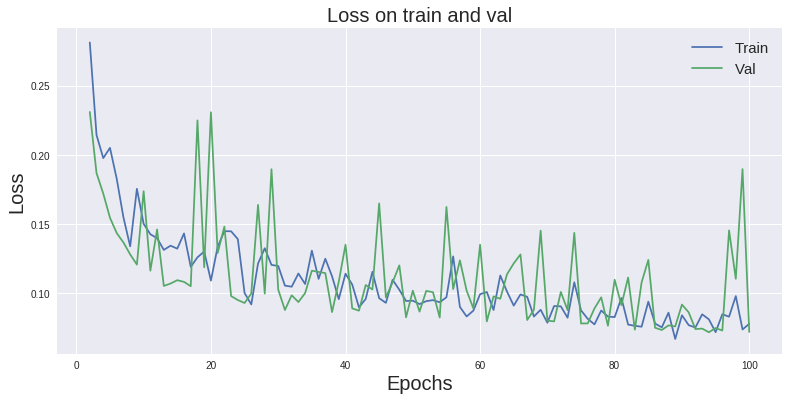

In [84]:
plt.plot(range(2, num_epochs + 1), train_losses[1:], label = 'Train')
plt.plot(range(2, num_epochs + 1), val_losses[1:], label = 'Val')
plt.legend(loc = 'best',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

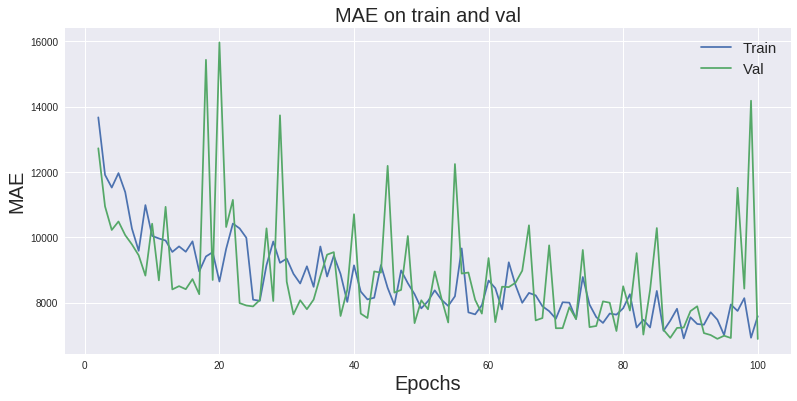

In [85]:
plt.plot(range(2, num_epochs + 1), train_maes[1:], label = 'Train')
plt.plot(range(2, num_epochs + 1), val_maes[1:], label = 'Val')
plt.legend(loc = 'best',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

In [88]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.cpu().data.numpy()
    val_mae += compute_mae(reference, prediction).cpu().data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


	Loss:	0.07194
	MAE:	6888.64913





In [93]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses) + 1, val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes) + 1, val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.07175211958538473 on epoch = 94, MAE on this epoch = 6892.791105941074
Best val MAE during iteration = 6888.649127795649 on epoch = 100, loss on this epoch = 0.07193958197349037


Видно что val-loss очень сильно скачет, но в целом есть некий тренд на убывание (так же это косвено доказывается тем, что наилучшие значения метрик были в последних эпохах). Попытаемся улучшить модель с помощью дальнейших усложнений в Task 4

### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def drop_token(sample, index):
  tensor = torch.tensor(sample, dtype=torch.int64).cuda()
  tensor[0, index] = UNK_IX
  return tensor

def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    batch = generate_batch(pd.DataFrame([sample]), 1)
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    #assert(sample[col_name].shape[0] == 1)
    # compute model prediction on sample (scalar float log-salary)
 
    baseline_pred = model(title_ix, desc_ix, cat_features).cpu().data.numpy()
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = [0] * batch[col_name].shape[1]
    
    for i in range(batch[col_name].shape[1]):
      if col_name == 'Title':
        title_ix = drop_token(batch[col_name], i)
      elif col_name == 'FullDescription':
        desc_ix = drop_token(batch[col_name], i)
      else:
        raise RuntimeError
      
      predictions_without_word[i] = model(title_ix, desc_ix, cat_features).cpu().data.numpy()
    
    score_differences = [
        prediction - baseline_pred for prediction in predictions_without_word
    ]
    
    # return a list of pairs: [(token, score_difference)]
    sample_text = sample[col_name].split()
    return [(sample_text[i], score_differences[i]) for i in range(batch[col_name].shape[1])]

In [149]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             70248137
Title                                          network engineer / cisco
FullDescription       network engineer / cisco an opportunity has ar...
LocationRaw                                   Yorkshire Harrogate HG1 1
LocationNormalized                                          Burn Bridge
ContractType                                                        NaN
ContractTime                                                  permanent
Company                                                           Other
Category                                                        IT Jobs
SalaryRaw                                           42000.00 GBP Annual
SalaryNormalized                                                  42000
SourceName                                                 jobserve.com
Log1pSalary                                                     10.6454
Name: 133421, dtype: object
[('network', array([0.0486869

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % (rgba[0, 0], rgba[0,1], rgba[0, 2])
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [160]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
batch = generate_batch(pd.DataFrame([sample]), 1)
title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
print("Salary (gbp):", model(title_ix, desc_ix, cat_features))

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 90853
Salary (gbp): tensor([10.3933], device='cuda:0', grad_fn=<SelectBackward>)


web content manager oxford

we are currently looking for a web development content manager to manage the company ’ s global web content of the ecommerce platform across multiple different geographies . this role will work to optimise onsite consumer experience and ensuring all marketing activity is executed on the site in accordance with the strategy and activity across all geographies each month whilst meeting , and aiming to exceed , the direct set sales targets . they will be responsible for managing and delivering new site launches for the business as well managing the web development road map for site and functionality enhancements . key accountabilities : responsible for managing , driving and executing the web content across all sites , paying close attention to localisation . responsible for maintaining the localisation activity planners and the execution of local market content . working closely with the email online campaign manager you will be responsible for the timely delivery of promotional content to the website , including new product releases , bespoke landing pages and any additional added value content . defining and agreeing project scope , outputs , and timescale , quality and cost establishing project structures , roles and teams , and then planning , monitoring and reporting on their work working with the wider ebusiness team to resolve live service incidents , allocate the right resources and communicate progress work with all members of the online team to ensure consistency across all online channels . to assist the head of ecommerce with ad hoc duties as and when required . key activities ensure that all geographies content is optimised and localised , through development of the web content activity planners . briefing assets to the design team , building the campaigns within the cms tool and deployment . working in conjunction with the email online campaign manager to fully delivery all site content , promotions and the development plan on time and in budget . managing the web development roadmap works on a daily basis with web development agency analysis and reporting of onsite metrics and make and implement changes to drive improvements . for more information please contact chris bubb at madison bridge associates . this job was originally posted as www . totaljobs . com / jobseeking / webcontentmanageroxford_job ****

Как видим мы закрасили те слова, которые влияют на зарплату (например слово manager явно влияет)

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

Я буду реализовывать пункт и смотреть изменилось ли качество. Для удобства мы загоним код тренировки в одну функцию

In [0]:
def train_model(model, opt, num_epochs = 100, max_len = 100, batch_size = 32, batches_per_epoch = 100):
    train_losses = np.zeros(num_epochs).astype(float)
    val_losses = np.zeros(num_epochs).astype(float)

    train_maes = np.zeros(num_epochs).astype(float)
    val_maes = np.zeros(num_epochs).astype(float) 

    for epoch_i in tnrange(num_epochs):
    
        if epoch_i % 10 == 0:
            print("Training after {} epochs".format(epoch_i + 1))
    
        train_loss = train_mae = train_batches = 0    
        model.train(True)
    
        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch, verbose = False):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
            reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.cpu().data.numpy()
            train_mae += compute_mae(reference, prediction).cpu().data.numpy()
            train_batches += 1
    
        train_losses[epoch_i] = train_loss / train_batches
        train_maes[epoch_i] = train_mae / train_batches
    
        if epoch_i % 10 == 0:
            print("\tLoss:\t%.5f" % (train_loss / train_batches))
            print("\tMAE:\t%.5f" % (train_mae / train_batches))
            print('\n\n')
    
        if epoch_i % 10 == 0:
            print("Validation after {} epochs".format(epoch_i + 1))
    
        val_loss = val_mae = val_batches = 0
        model.train(False)
    
        for batch in iterate_minibatches(data_val, shuffle=False, verbose = False):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
            reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()
            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.cpu().data.numpy()
            val_mae += compute_mae(reference, prediction).cpu().data.numpy()
            val_batches += 1
    
        val_losses[epoch_i] = val_loss / val_batches
        val_maes[epoch_i] = val_mae / val_batches
    
        if epoch_i % 10 == 0:  
            print("\tLoss:\t%.5f" % (val_loss / val_batches))
            print("\tMAE:\t%.5f" % (val_mae / val_batches))
            print('\n\n')

    return train_losses, train_maes, val_losses, val_maes

In [222]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, train_maes, val_losses, val_maes = train_model(model, opt)

Training after 1 epochs
	Loss:	5.37476
	MAE:	138252.36989



Validation after 1 epochs
	Loss:	0.30200
	MAE:	14421.46822



Training after 11 epochs
	Loss:	0.14426
	MAE:	10232.99939



Validation after 11 epochs
	Loss:	0.10998
	MAE:	8586.71615



Training after 21 epochs
	Loss:	0.14636
	MAE:	10582.11467



Validation after 21 epochs
	Loss:	0.13238
	MAE:	9249.00769



Training after 31 epochs
	Loss:	0.11069
	MAE:	9058.16213



Validation after 31 epochs
	Loss:	0.18380
	MAE:	13266.81292



Training after 41 epochs
	Loss:	0.15098
	MAE:	10610.90479



Validation after 41 epochs
	Loss:	0.08234
	MAE:	7485.65743



Training after 51 epochs
	Loss:	0.10161
	MAE:	8346.59508



Validation after 51 epochs
	Loss:	0.09539
	MAE:	8445.69154



Training after 61 epochs
	Loss:	0.08823
	MAE:	8055.89954



Validation after 61 epochs
	Loss:	0.11814
	MAE:	9824.10113



Training after 71 epochs
	Loss:	0.07622
	MAE:	7275.69181



Validation after 71 epochs
	Loss:	0.07430
	MAE:	7168.65900



Training after 81 e

In [223]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses) + 1, val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes) + 1, val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.0695330869187327 on epoch = 94, MAE on this epoch = 6784.831635837929
Best val MAE during iteration = 6784.831635837929 on epoch = 94, loss on this epoch = 0.0695330869187327


In [0]:
train_loss_experiments = []
train_mae_experiments = []
val_loss_experiments = []
val_mae_experiments = []

In [0]:
train_loss_experiments.append((np.copy(train_losses), 'before experiments'))
train_mae_experiments.append((np.copy(train_maes), 'before experiments'))

val_loss_experiments.append((np.copy(val_losses), 'before experiments'))
val_mae_experiments.append((np.copy(val_maes), 'before experiments'))

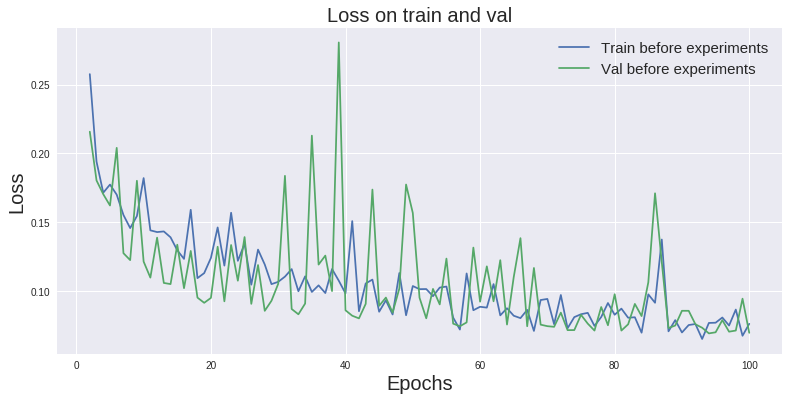

In [226]:
for i in range(len(train_loss_experiments)):
  num_epochs = train_loss_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_loss_experiments[i][0][1:], label = 'Train ' + train_loss_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_loss_experiments[i][0][1:], label = 'Val ' + val_loss_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

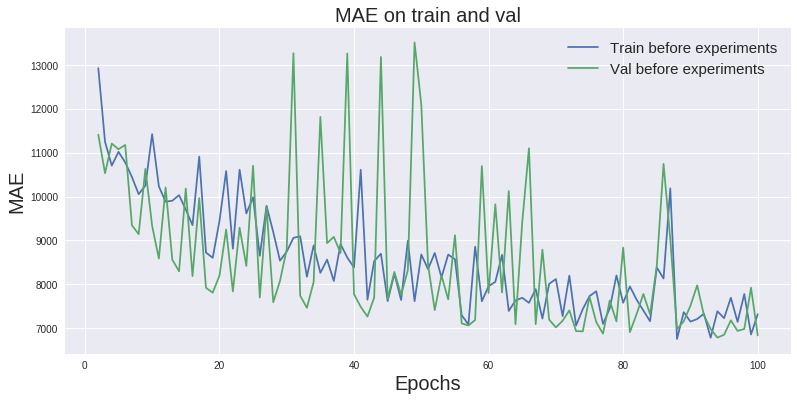

In [227]:
for i in range(len(train_mae_experiments)):
  num_epochs = train_mae_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_mae_experiments[i][0][1:], label = 'Train ' + train_mae_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_mae_experiments[i][0][1:], label = 'Val ' + val_mae_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

## A

### Add batchnorm

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.norm = nn.BatchNorm1d(out_size).cuda()
        self.pool1 = GlobalMaxPooling().cuda()
        self.dense = nn.Linear(out_size, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense((self.pool1(self.norm(self.conv1(h)))))

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.norm_1 = nn.BatchNorm1d(out_size).cuda()
        self.relu = nn.ReLU().cuda()
        self.pool1 = nn.MaxPool1d(2).cuda()
        self.conv2 = nn.Conv1d(out_size, out_size * 2, kernel_size=3, padding=1).cuda()
        self.norm_2 = nn.BatchNorm1d(out_size * 2).cuda()
        self.pool2 = GlobalMaxPooling().cuda()
        
        self.dense = nn.Linear(out_size * 2, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.pool2(self.norm_2(self.relu(self.conv2(self.pool1(self.norm_1(self.conv1(h))))))))

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.title_norm = nn.BatchNorm1d(64).cuda()
        
        self.desc_encoder = DescriptionEncoder(out_size = 128)
        self.desc_norm = nn.BatchNorm1d(128).cuda()
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_1 = nn.Linear(n_cat_features, 512).cuda()
        self.norm_1 = nn.BatchNorm1d(512).cuda()
        self.relu_1 = nn.ReLU().cuda()
        self.dense_2 = nn.Linear(512, 256).cuda()
        self.norm_2 = nn.BatchNorm1d(256).cuda()
        self.relu_2 = nn.ReLU().cuda()
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(64 + 128 + 256, 1024).cuda()
        self.out_norm = nn.BatchNorm1d(1024).cuda()
        self.out_relu = nn.ReLU().cuda()
        self.predict = nn.Linear(1024, 1).cuda()
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_norm(self.title_encoder(title_ix))
        desc_h = self.desc_norm(self.desc_encoder(desc_ix))
        
        # apply categorical encoder
        cat_h = self.relu_2(self.norm_2(self.dense_2(self.relu_1(self.norm_1(self.dense_1(cat_features))))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        output = self.predict(self.out_relu(self.out_norm(self.output(joint_h))))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

In [248]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, train_maes, val_losses, val_maes = train_model(model, opt)

Training after 1 epochs
	Loss:	18.16596
	MAE:	35198.37045



Validation after 1 epochs
	Loss:	0.85398
	MAE:	22734.60428



Training after 11 epochs
	Loss:	0.21700
	MAE:	12558.81235



Validation after 11 epochs
	Loss:	0.22688
	MAE:	12243.84779



Training after 21 epochs
	Loss:	0.17880
	MAE:	11395.96691



Validation after 21 epochs
	Loss:	0.19714
	MAE:	10990.00524



Training after 31 epochs
	Loss:	0.13522
	MAE:	9864.16881



Validation after 31 epochs
	Loss:	0.12045
	MAE:	9156.39474



Training after 41 epochs
	Loss:	0.12204
	MAE:	9275.52153



Validation after 41 epochs
	Loss:	0.11207
	MAE:	8764.14158



Training after 51 epochs
	Loss:	0.12137
	MAE:	9070.47456



Validation after 51 epochs
	Loss:	0.09317
	MAE:	7983.80522



Training after 61 epochs
	Loss:	0.11590
	MAE:	8998.51285



Validation after 61 epochs
	Loss:	0.08727
	MAE:	7607.02664



Training after 71 epochs
	Loss:	0.09100
	MAE:	8068.27758



Validation after 71 epochs
	Loss:	0.11030
	MAE:	8359.72115



Training after 81 e

In [249]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses) + 1, val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes) + 1, val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.06899045111453221 on epoch = 97, MAE on this epoch = 6767.904483570772
Best val MAE during iteration = 6767.904483570772 on epoch = 97, loss on this epoch = 0.06899045111453221


In [0]:
train_loss_experiments.append((np.copy(train_losses), 'add batch_norm'))
train_mae_experiments.append((np.copy(train_maes), 'add batch_norm'))

val_loss_experiments.append((np.copy(val_losses), 'add batch_norm'))
val_mae_experiments.append((np.copy(val_maes), 'add batch_norm'))

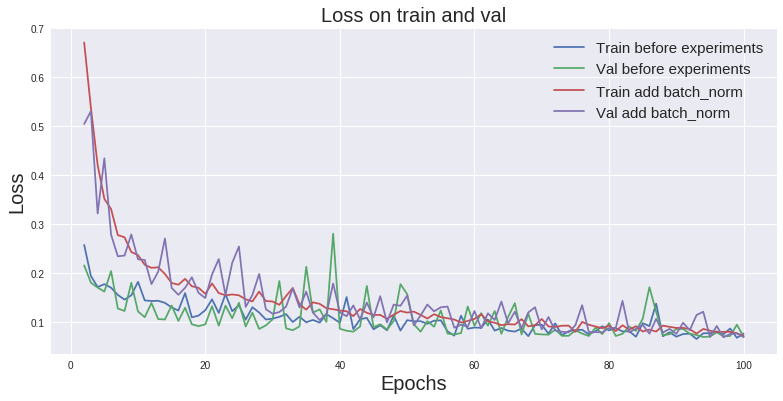

In [251]:
for i in range(len(train_loss_experiments)):
  num_epochs = train_loss_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_loss_experiments[i][0][1:], label = 'Train ' + train_loss_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_loss_experiments[i][0][1:], label = 'Val ' + val_loss_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('Loss on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('Loss', size = 20)
plt.show()

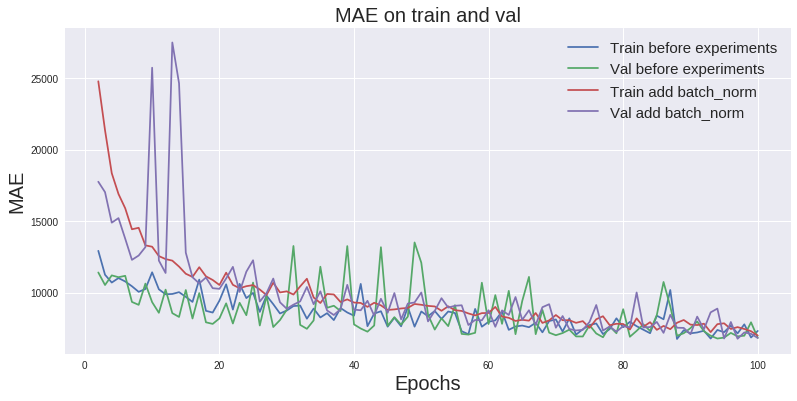

In [252]:
for i in range(len(train_mae_experiments)):
  num_epochs = train_mae_experiments[i][0].shape[0]
  plt.plot(range(2, num_epochs + 1), train_mae_experiments[i][0][1:], label = 'Train ' + train_mae_experiments[i][1])
  plt.plot(range(2, num_epochs + 1), val_mae_experiments[i][0][1:], label = 'Val ' + val_mae_experiments[i][1])

plt.legend(loc = 'upper right',  prop={'size': 15})
plt.title('MAE on train and val', size = 20)
plt.xlabel('Epochs', size = 20)
plt.ylabel('MAE', size = 20)
plt.show()

Сильного улучшения мы не получлии, но замечу что скдя по графику val стал гораздо стабильнее (меньше пиков)

### Parallel convolution layers

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size // 2, kernel_size=3, padding=1).cuda()
        self.norm1 = nn.BatchNorm1d(out_size // 2).cuda()
        self.conv2 = nn.Conv1d(64, out_size // 2, kernel_size=3, padding=1).cuda()
        self.norm2 = nn.BatchNorm1d(out_size // 2).cuda()
        self.pool = GlobalMaxPooling().cuda()
        self.dense = nn.Linear(out_size, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense((self.pool1(self.norm(self.conv1(h)))))

In [210]:
train_losses, train_maes, val_losses, val_maes = train_model(model, opt, num_epochs = 50)

Training after 1 epochs
	Loss:	0.19819
	MAE:	12171.10165



Validation after 1 epochs
	Loss:	0.08019
	MAE:	7344.06841



Training after 11 epochs
	Loss:	0.19798
	MAE:	12104.73661



Validation after 11 epochs
	Loss:	0.10181
	MAE:	9028.72445



Training after 21 epochs
	Loss:	0.20306
	MAE:	12154.07876



Validation after 21 epochs
	Loss:	0.12460
	MAE:	9197.04317



Training after 31 epochs
	Loss:	0.19941
	MAE:	12260.79138



Validation after 31 epochs
	Loss:	0.09170
	MAE:	8174.10926



Training after 41 epochs
	Loss:	0.19038
	MAE:	11935.96181



Validation after 41 epochs
	Loss:	0.09567
	MAE:	8499.95542





In [211]:
print("Best val loss during iteration = {} on epoch = {}, MAE on this epoch = {}"\
      .format(np.min(val_losses), np.argmin(val_losses) + 101, val_maes[np.argmin(val_losses)]))
print("Best val MAE during iteration = {} on epoch = {}, loss on this epoch = {}"\
      .format(np.min(val_maes), np.argmin(val_maes) + 101, val_losses[np.argmin(val_maes)]))

Best val loss during iteration = 0.07896002437554153 on epoch = 127, MAE on this epoch = 7358.437689568014
Best val MAE during iteration = 7315.232638569751 on epoch = 138, loss on this epoch = 0.0792310412364458


Dropout пока не силньо улучшил (даже слегка ухудшил), но давайте попробуем усложнить модель добавив batchnorm и понадемся, что со сложной моделью dropout будет лучше работать

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.norm = nn.BatchNorm1d(out_size).cuda()
        self.pool1 = GlobalMaxPooling().cuda()
        self.dense = nn.Linear(out_size, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense((self.pool1(self.norm(self.conv1(h)))))

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX).cuda()
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1).cuda()
        self.norm_1 = nn.BatchNorm1d(out_size).cuda()
        self.pool1 = nn.MaxPool1d(2).cuda()
        self.conv2 = nn.Conv1d(out_size, out_size * 2, kernel_size=3, padding=1).cuda()
        self.pool2 = GlobalMaxPooling().cuda()
        self.norm_2 = nn.BatchNorm1d(out_size * 2)
        
        self.dense = nn.Linear(out_size * 2, out_size).cuda()

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense. 
        return self.dense(self.norm_2(self.pool2(self.conv2(self.norm_1(self.pool1(self.conv1(h)))))))

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.title_norm = nn.BatchNorm2d(64).cuda()

        self.desc_encoder = DescriptionEncoder(out_size = 128)
        self.desc_norm = nn.BatchNorm2d(128).cuda()
        
        # define layers for categorical features. A few dense layers would do.
        self.dense_1 = nn.Linear(n_cat_features, 512).cuda()
        self.norm_1 = nn.BatchNorm2d(512)
        self.relu_1 = nn.ReLU().cuda()
        self.drop_1 = nn.Dropout(0.1).cuda()
        self.dense_2 = nn.Linear(512, 256).cuda()
        self.norm_2 = nn.BatchNorm2d(256)
        self.relu_2 = nn.ReLU().cuda()
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Linear(64 + 128 + 256, 1024).cuda()
        self.out_norm = nn.BatchNorm2d(1024).cuda()
        self.out_relu = nn.ReLU().cuda()
        self.drop_2 = nn.Dropout(0.3).cuda()
        self.predict = nn.Linear(1024, 1).cuda()
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_norm(self.title_encoder(title_ix))
        desc_h = self.desc_norm(self.desc_encoder(desc_ix))
        
        # apply categorical encoder
        cat_h = self.relu_2(self.norm_2(self.dense_2(self.drop_1(self.relu_1(self.norm_1(self.dense_1(cat_features)))))))
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        
        output = self.predict(self.drop_2(self.out_relu(self.output(joint_h))))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return output[:, 0]

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...